In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [3]:
# -------------------------------
# 1) Загрузка и базовая предобрабока
# -------------------------------
df = pd.read_csv('phones.csv')  # ожидает колонки disk, os, price, year

# Приведём типы и создадим признак age
df['disk'] = pd.to_numeric(df['disk'].astype(str).str.replace(r'[^0-9\.]', '', regex=True), errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # можно использовать в аналитике по кластерам
current_year = pd.Timestamp.now().year
df['age'] = current_year - df['year']

# Убираем строки с критическими пропусками (disk или os или age)
df = df.dropna(subset=['disk', 'os', 'age']).reset_index(drop=True)

In [4]:
# -------------------------------
# 2) Определяем признаки (без price, чтобы можно кластеризовать новые объекты без цены)
# -------------------------------
numeric_features = ['disk', 'age']
categorical_features = ['os']

# ColumnTransformer: one-hot для категориальных, масштабирование для числовых
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

In [5]:
# -------------------------------
# 3) Помощники для выбора k (elbow + silhouette)
# -------------------------------
def find_k_elbow_silhouette(x_transformed, k_min=2, k_max=8):
    inertias = []
    silhouettes = []
    K = list(range(k_min, k_max + 1))
    for k in K:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(x_transformed)
        inertias.append(km.inertia_)
        # silhouette_score требует >1 кластер и <n_samples
        if len(set(labels)) > 1 and len(labels) > k:
            silhouettes.append(silhouette_score(x_transformed, labels))
        else:
            silhouettes.append(np.nan)
    return K, inertias, silhouettes

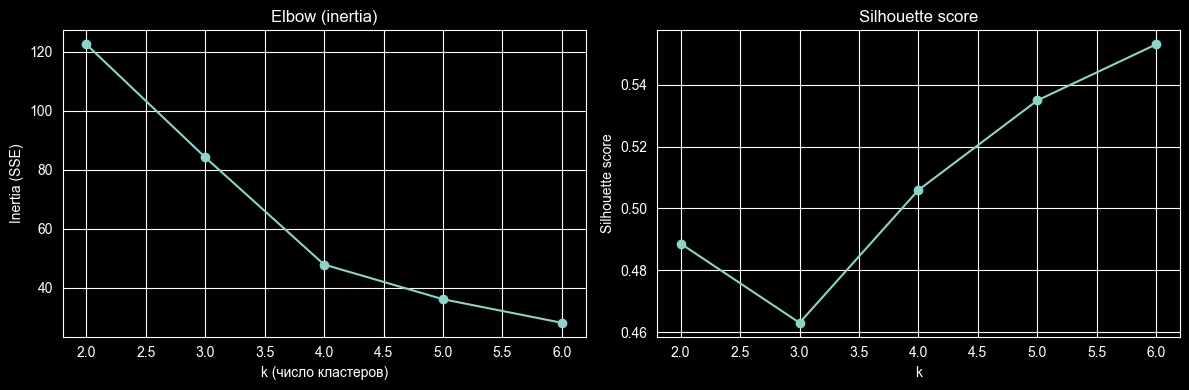

In [6]:
# -------------------------------
# 4) Pipeline (preprocessor + KMeans(placeholder))
# -------------------------------
# На этом этапе мы сначала подготавливаем признаки, затем отдельно ищем k,
# затем создадим Pipeline с выбранным k.
prep_only = Pipeline(steps=[('preproc', preprocessor)])

# Получаем матрицу признаков (числовую) для поиска k
X_prepared = prep_only.fit_transform(df)

# Подбор k
K_vals, inertias, silhouettes = find_k_elbow_silhouette(X_prepared, k_min=2, k_max=6)

# Визуализация Elbow + Silhouette (помогает выбрать k)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_vals, inertias, '-o')
plt.xlabel('k (число кластеров)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow (inertia)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(K_vals, silhouettes, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# -------------------------------
# 5) Выбираем k (можно менять вручную; здесь берем тот, где silhouette максимален)
# -------------------------------
best_idx = int(np.nanargmax(silhouettes))   # индекс лучшего silhouette (игнорирует nan)
best_k = K_vals[best_idx]
print(f"Выбранное k по silhouette: {best_k}")

Выбранное k по silhouette: 6


In [8]:
# -------------------------------
# 6) Обучаем финальный Pipeline с KMeans(best_k)
# -------------------------------
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=20))
])

pipeline.fit(df)  # ColumnTransformer в pipeline возьмёт нужные колонки из df

# Присвоим кластеры исходным записям
df['cluster'] = pipeline.named_steps['kmeans'].labels_.astype(int)

# Вычислим центры кластеров в исходных единицах (инверсируем StandardScaler + OneHot сложно инвертировать полностью,
# но можем получить центры в пространстве признаков после inverse_transform подготовки)
# Получим центры в подготовленном пространстве и обратим масштаб числовой части вручную:
kmeans = pipeline.named_steps['kmeans']
# Получаем подготовленные X (как при обучении)
X_prepared_full = pipeline.named_steps['preproc'].transform(df)  # numeric scaled + one-hot
centers_prepared = kmeans.cluster_centers_

# Чтобы показать центр в "человеческом" виде — преобразуем подготовленный в частично обратимый:
#  - числовая часть: inverse transform через StandardScaler
#  - категориальная часть: покажем наиболее частый dummy (argmax)
num_scaler = pipeline.named_steps['preproc'].named_transformers_['num']
cat_encoder = pipeline.named_steps['preproc'].named_transformers_['cat']
num_cols = numeric_features
cat_cols = cat_encoder.get_feature_names_out(categorical_features)

centers_df = []
for i, c in enumerate(centers_prepared):
    num_part = c[:len(num_cols)]
    cat_part = c[len(num_cols):]
    num_orig = num_scaler.inverse_transform(num_part.reshape(1,-1)).flatten()
    # для категориальной части вытянем индекс '1' (т.е. наиболее близкий dummy) — приближённо
    cat_idx = np.argmax(cat_part)
    cat_name = cat_cols[cat_idx]
    centers_df.append({
        'cluster': i,
        **{num_cols[j]: round(float(num_orig[j]), 2) for j in range(len(num_cols))},
        'dominant_cat_dummy': cat_name
    })
centers_df = pd.DataFrame(centers_df)

print("\nЦентры кластеров (приближённо):")
print(centers_df)


Центры кластеров (приближённо):
   cluster    disk    age dominant_cat_dummy
0        0  256.00   8.36             os_iOS
1        1   52.48  12.88         os_Android
2        2  256.00  12.70             os_iOS
3        3   61.71   8.86         os_Android
4        4  512.00  13.15             os_iOS
5        5  512.00   9.08             os_iOS


In [9]:
# -------------------------------
# 7) Краткая агрегация: размер кластера и средняя цена (для бизнес-интерпретации)
# -------------------------------
cluster_summary = df.groupby('cluster').agg(
    count=('disk','size'),
    mean_price=('price','mean'),
    median_price=('price','median')
).reset_index()
print("\nСводка по кластерам (count, mean_price, median_price):")
print(cluster_summary)


Сводка по кластерам (count, mean_price, median_price):
   cluster  count    mean_price  median_price
0        0     11  11702.727273       11910.0
1        1     25   3655.280000        4277.0
2        2     10   7319.000000        7516.0
3        3     28   7750.285714        7552.5
4        4     13   9479.230769        9392.0
5        5     13  13662.538462       12797.0


In [10]:
# -------------------------------
# 8) Применение модели к новым объектам (пример)
# -------------------------------
new = pd.DataFrame([
    {'disk': 64, 'os': 'Android', 'year': 2019},
    {'disk': 512, 'os': 'iOS', 'year': 2019}
])
new['age'] = current_year - new['year']
# Pipeline умеет брать данные с именованными колонками, поэтому передаём new напрямую:
predicted_clusters = pipeline.predict(new)   # даёт метку кластера
# distances: метод transform возвращает расстояние до центров в KMeans (если нужен)
distances = pipeline.named_steps['kmeans'].transform(pipeline.named_steps['preproc'].transform(new))

print("\nНовые примеры и предсказанные кластеры:")
print(pd.concat([new.reset_index(drop=True),
                 pd.DataFrame({'pred_cluster': predicted_clusters}),
                 pd.DataFrame(distances, columns=[f'dist_to_c{i}' for i in range(best_k)])], axis=1))


Новые примеры и предсказанные кластеры:
   disk       os  year  age  pred_cluster  dist_to_c0  dist_to_c1  dist_to_c2  \
0    64  Android  2019    6             3    1.992347    2.879407    3.294047   
1   512      iOS  2019    6             5    1.655433    3.995702    3.101896   

   dist_to_c3  dist_to_c4  dist_to_c5  
0    1.195568    4.044423    3.009098  
1    2.980191    2.993372    1.287472  


In [11]:
# -------------------------------
# 9) Сохранение pipeline (предобработка + модель)
# -------------------------------
joblib.dump(pipeline, 'kmeans_pipeline.joblib')
print("\nPipeline с KMeans сохранён в 'kmeans_pipeline.joblib'")

# -------------------------------


Pipeline с KMeans сохранён в 'kmeans_pipeline.joblib'
